# __Кластеризація...__ simple 2D

алгоритм `K-means` для кластеризації

In [1]:
import os
from pathlib import Path
import random
from typing import Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [2]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    # tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

In [3]:
def read_from_csvfile(file: Path, header: Optional[str]='infer') -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file, header=header)
    
    return df

Читаємо всі датасети з файлів `csv` у папці `data2`

In [4]:
dfs = [read_from_csvfile(item, None) for item in Path('data2').iterdir() if item.is_file() and item.suffix.lower() in ('.csv',)]

Виділяємо різні набори

In [5]:
data_2d, mnist = dfs[0], dfs[1]

In [6]:
mnist.shape, data_2d.shape

((500, 785), (200, 3))

In [7]:
data_2d.columns = ['y', 'x1', 'x2']

In [8]:
data_2d.head(3)

,y,x1,x2
0,0.0,-0.768716,0.460860
1,0.0,2.687848,2.366961
2,0.0,-0.201379,0.470430


In [9]:
not data_2d['y'].is_unique, data_2d['y'].min(), data_2d['y'].max()

(True, 0.0, 1.0)

##### SCRUB & EXPLORE

In [10]:
def draw_2D_scatter(as_x: list, as_y: list, mark: Optional[str], title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x)) / len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x)) / len(as_x))/10 or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y)) / len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y)) / len(as_y))/10 or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    plt.xticks(rotation=85)
    
    plt.scatter(as_x, as_y) if mark is None else plt.scatter(as_x, as_y, c=mark, cmap='viridis') 

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # ax.grid(which='both')
    plt.show()

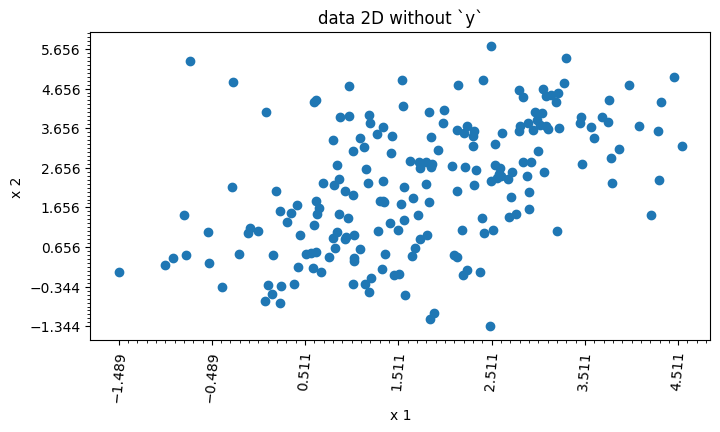

In [11]:
size = (8, 4)
draw_2D_scatter(as_x=data_2d['x1'], as_y=data_2d['x2'], mark=None, title=f'data 2D without `y`', xlabel='x 1', ylabel=f'x 2', figsize=size)

Як бачимо з меж, попередня нормалізація - зайва

### __`MODEL`__ & __`Training`__

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Розрахуємо для розбиття на кластери від 1 до 11

In [12]:
X = data_2d[['x1', 'x2']].to_numpy()
x = [n_clus for n_clus in range(1, 12)]
kmeans = [KMeans(n_clusters=n_clus, random_state=0, n_init='auto').fit(X) for n_clus in x]

In [13]:
y = [km.inertia_ for km in kmeans]

In [14]:
def draw_2D(as_x: list, as_y: list, title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)/10) or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)/10) or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

    plt.plot(
             as_x, 
             as_y, 
            #  label=f'2D', 
             color=random.choice('rgbcmyk'), 
             linestyle=random.choice(['-', '--', '-.', ':', None]),
             marker=random.choice('o+xdvs*.^')
             )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    ax.grid(which='both')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


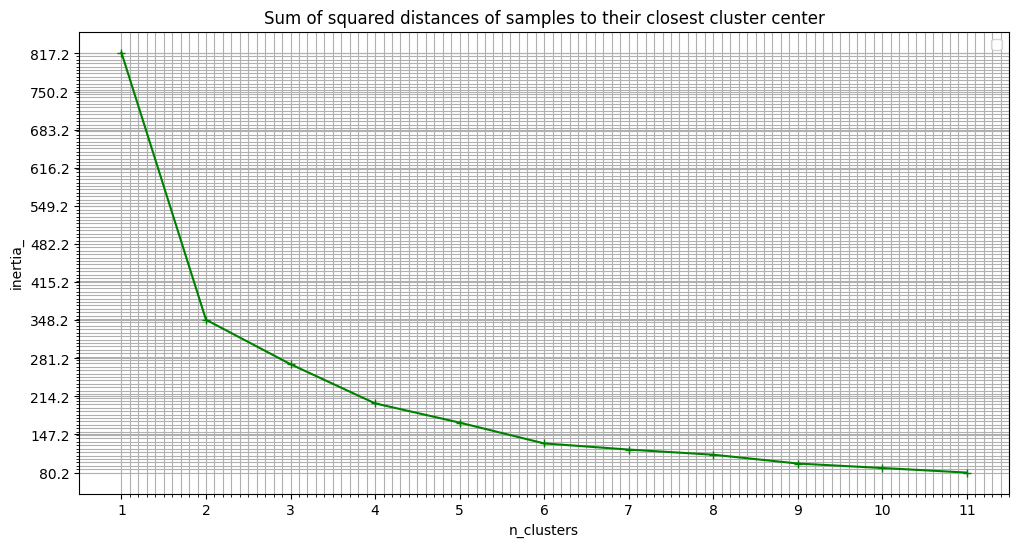

In [15]:
title = 'Sum of squared distances of samples to their closest cluster center'
draw_2D(as_x=x, as_y=y, title=title, xlabel='n_clusters', ylabel=f'inertia_', figsize=(12, 6))

Візуально начебто 2 кластери оптимально, але ...

- https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python
- https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
- https://github.com/arvkevi/kneed

In [16]:
kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')

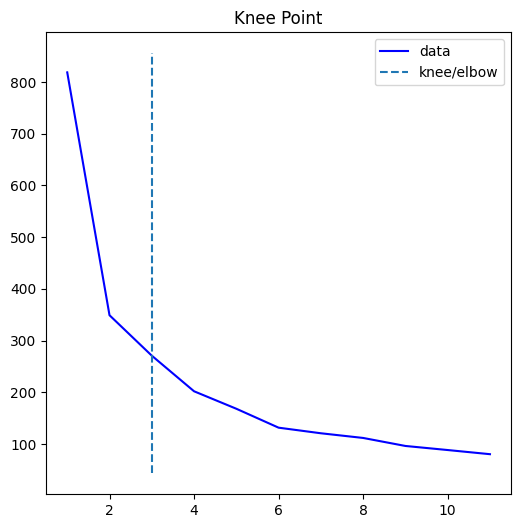

In [17]:
kneedle.plot_knee()

In [18]:
kneedle.knee, kneedle.knee_y

(3, 270.7630149091876)

За алгоритмом оптимального значення: кластерів 3, зі значенням (суми) найбільших квадратичних відхилень від центроїдів 270.76

Відносне зменшення значення найбільших квадратичних відхилень від центроїдів при покрокомому збільшенні кількості кластерів від 1:

In [19]:
[(y[el-1]-y[el])/y[el-1] for el in range(len(y)) if el != 0]

[0.5737653082456686,
 0.22409806759241713,
 0.25441836710633864,
 0.16743506444255113,
 0.21781515371328095,
 0.08226000723630648,
 0.07506702535704787,
 0.13883175893527078,
 0.0820044751856831,
 0.09101620656036621]

In [20]:
kmeans[1:3]

[KMeans(n_clusters=2, n_init='auto', random_state=0),
 KMeans(n_clusters=3, n_init='auto', random_state=0)]

### __`INTERPRET`__ / __`Error Analysis`__

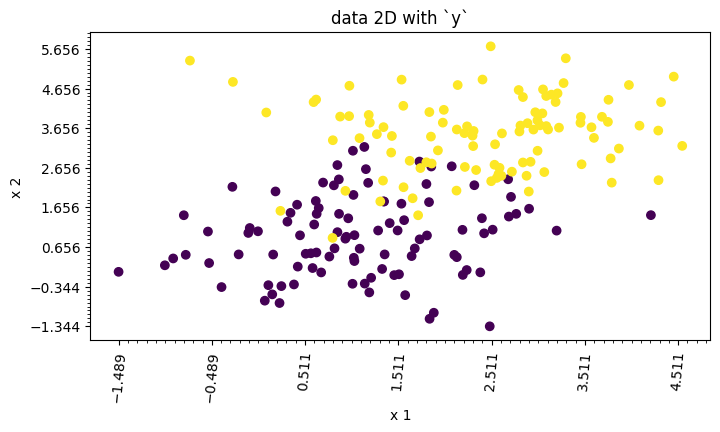

In [21]:
draw_2D_scatter(as_x=data_2d['x1'], as_y=data_2d['x2'], mark=data_2d['y'], title=f'data 2D with `y`', xlabel='x 1', ylabel=f'x 2', figsize=size)

###### Якщо взяти кластеризацію з розбиттям на __2 класи__

In [22]:
kmeans[1].labels_

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0], dtype=int32)

In [23]:
kmeans[1].cluster_centers_

array([[2.46540572, 3.48660748],
       [0.97799508, 0.80217417]])

In [24]:
centroids = pd.DataFrame(kmeans[1].cluster_centers_)
centroids.columns = ['x1', 'x2']
centroids

,x1,x2
0,2.465406,3.486607
1,0.977995,0.802174


Додамо результат кластеризації - позначення `y2`

In [25]:
y2 = pd.DataFrame({'y2':kmeans[1].labels_})
data_2d_c = pd.concat([data_2d, y2], axis=1)
data_2d_c.head()

,y,x1,x2,y2
0,0.0,-0.768716,0.460860,1
1,0.0,2.687848,2.366961,0
2,0.0,-0.201379,0.470430,1
3,0.0,0.608496,1.225400,1
4,0.0,-0.082282,1.137218,1


Додамо центроїди

In [26]:
c2 = pd.DataFrame({'y2':[centroids.shape[0]+1, centroids.shape[0]+2]})
c2 = pd.concat([c2, centroids], axis=1)
c2.head()

,y2,x1,x2
0,3,2.465406,3.486607
1,4,0.977995,0.802174


In [27]:
data_2d_c = pd.concat([data_2d_c, c2], axis=0, ignore_index=True)
data_2d_c.tail(3)

,y,x1,x2,y2
199,1.0,3.764228,4.372587,0
200,NaN,2.465406,3.486607,3
201,NaN,0.977995,0.802174,4


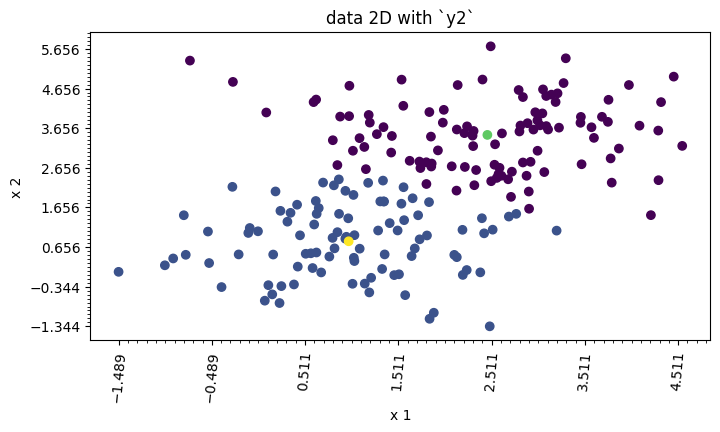

In [28]:
draw_2D_scatter(as_x=data_2d_c['x1'], as_y=data_2d_c['x2'], mark=data_2d_c['y2'], title=f'data 2D with `y2`', xlabel='x 1', ylabel=f'x 2', figsize=size)

###### Якщо взяти з кластеризацію з розбиттям на __3 класи__

In [29]:
kmeans[2].labels_

array([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0], dtype=int32)

In [30]:
kmeans[2].cluster_centers_

array([[2.67513782, 3.99328211],
       [0.74771856, 0.50438896],
       [1.96916569, 2.32414269]])

In [31]:
centroids = pd.DataFrame(kmeans[2].cluster_centers_)
centroids.columns = ['x1', 'x2']
centroids

,x1,x2
0,2.675138,3.993282
1,0.747719,0.504389
2,1.969166,2.324143


Додамо результат кластеризації - позначення `y3` та центроїди

In [32]:
y3 = pd.DataFrame({'y3':kmeans[2].labels_})
data_2d_c = pd.concat([data_2d, y3], axis=1)
c3 = pd.DataFrame({'y3':[centroids.shape[0] + i for i in range(centroids.shape[0])], })
c3 = pd.concat([c3, centroids], axis=1)
data_2d_c = pd.concat([data_2d_c, c3], axis=0, ignore_index=True)
data_2d_c.tail(3)

,y,x1,x2,y3
200,NaN,2.675138,3.993282,3
201,NaN,0.747719,0.504389,4
202,NaN,1.969166,2.324143,5


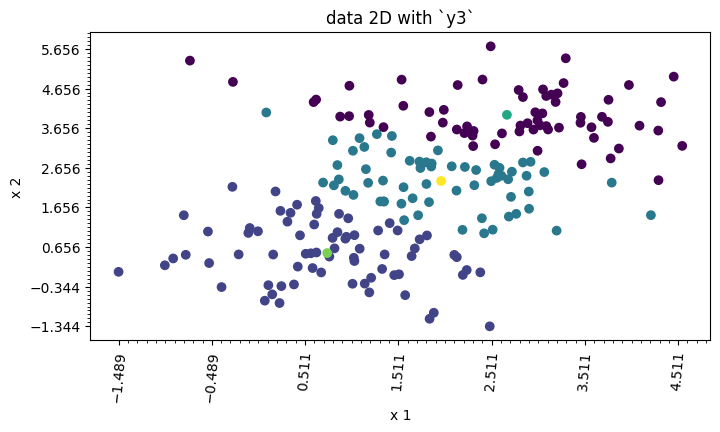

In [33]:
draw_2D_scatter(as_x=data_2d_c['x1'], as_y=data_2d_c['x2'], mark=data_2d_c['y3'], title=f'data 2D with `y3`', xlabel='x 1', ylabel=f'x 2', figsize=size)

### __`Implement`__

In [34]:
kmeans[1].predict([[0, 0], [1.5, 1.7], [2.5, 3.6], [2.6, -0.35], [-0.5, 3], [3.5, 0], [0.5, 5]])

array([1, 1, 0, 1, 1, 1, 0], dtype=int32)

In [35]:
kmeans[2].predict([[0, 0], [1.5, 1.7], [2.5, 3.6], [2.6, -0.35], [-0.5, 3], [3.5, 0], [0.5, 5]])

array([1, 2, 0, 1, 2, 2, 0], dtype=int32)